In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Flatten, Add, Dropout, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from keras.preprocessing.image import ImageDataGenerator


In [2]:
# data preparation
dataset_dir =  r'D:\Project\Deep Learning - Research\programs\MV-couswork\Brain Tumor Data Set\BrainTumorProcessed'
input_shape = (256, 256, 3)
batch_size = 2
num_classes = 2

In [3]:
# data augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = ImageDataGenerator(
rescale = 1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 3103 images belonging to 2 classes.
Found 665 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


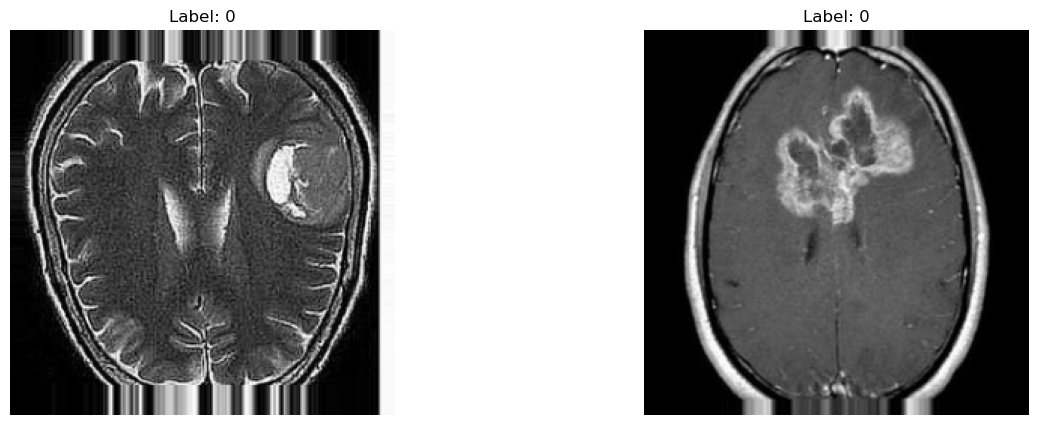

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [9]:
def residual_block(inputs, num_filter):
    # Convolution layers
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Skip connection
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(2*num_filter, kernel_size=(1,1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut=inputs
        
    shortcut = MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(shortcut)
    
    # add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
 def VGG_residual(inputs_shape):    
    inputs = Input(shape=input_shape)
    
    # Residual blocks 
    x = residual_block(inputs, 64) # 2 conv layers
    x = residual_block(x, 256) # 2 conv layers
    

    # Flatten the layers
    x = Flatten()(x)

    # Add fully connected layers
    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Third fully connected layer
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [11]:
model = VGG_residual(input_shape)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_10[0][0]']              
                                )                                                             

In [13]:

model.compile(loss='binary_crossentropy', optimizer='adaGrad', metrics=['accuracy'])

In [16]:
history = model.fit(train_generator, epochs=50, validation_data =(validation_generator), verbose=1)

Epoch 1/50
1552/1552 [==============================] - 87s 49ms/step - loss: 1.2091 - accuracy: 0.5904 - val_loss: 0.6036 - val_accuracy: 0.6797
Epoch 2/50
1552/1552 [==============================] - 72s 46ms/step - loss: 0.6017 - accuracy: 0.6623 - val_loss: 0.5611 - val_accuracy: 0.6887
Epoch 3/50
1552/1552 [==============================] - 72s 47ms/step - loss: 0.5477 - accuracy: 0.7100 - val_loss: 0.5049 - val_accuracy: 0.7429
Epoch 4/50
1552/1552 [==============================] - 72s 46ms/step - loss: 0.5120 - accuracy: 0.7406 - val_loss: 0.5057 - val_accuracy: 0.7459
Epoch 5/50
1552/1552 [==============================] - 72s 46ms/step - loss: 0.4852 - accuracy: 0.7531 - val_loss: 0.5018 - val_accuracy: 0.7263
Epoch 6/50
1552/1552 [==============================] - 72s 46ms/step - loss: 0.4785 - accuracy: 0.7586 - val_loss: 0.4555 - val_accuracy: 0.7594
Epoch 7/50
1552/1552 [==============================] - 72s 47ms/step - loss: 0.4563 - accuracy: 0.7773 - val_loss: 0.4518 -

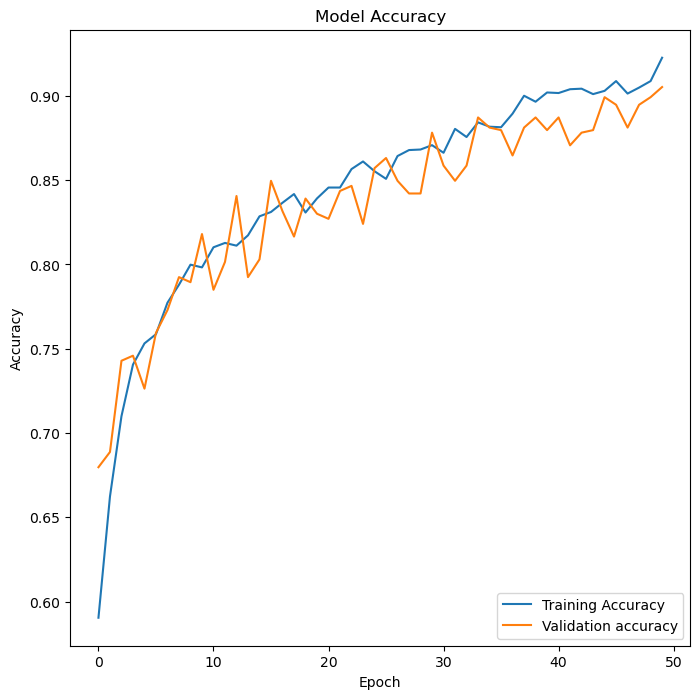

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation accuracy'], loc='lower right')

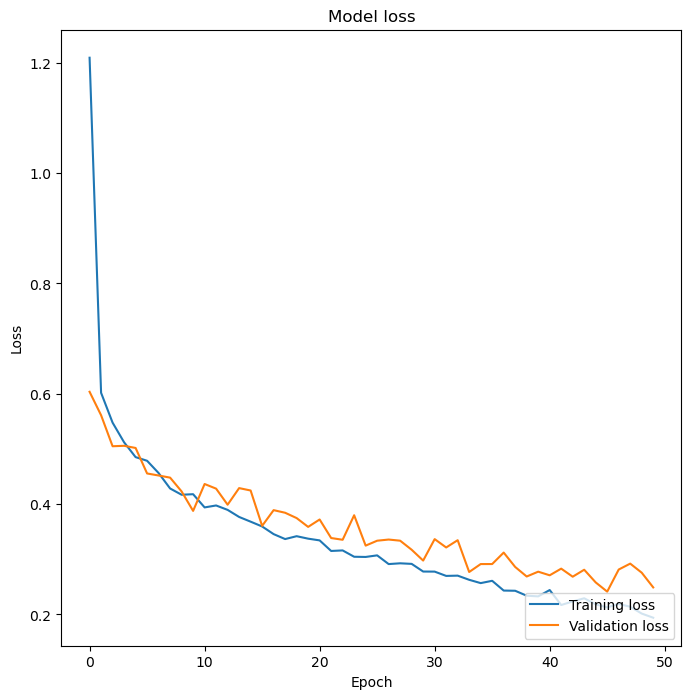

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [19]:
loss, accurancy = model.evaluate(test_generator)
print('Test loss:', loss)
print("Test accurancy", accurancy)

333/333 [==============================] - 5s 14ms/step - loss: 0.2092 - accuracy: 0.9279
Test loss: 0.2092152237892151
Test accurancy 0.9279279112815857


In [20]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[195 159]
 [163 149]]


In [21]:
#compute f1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.4806451612903226


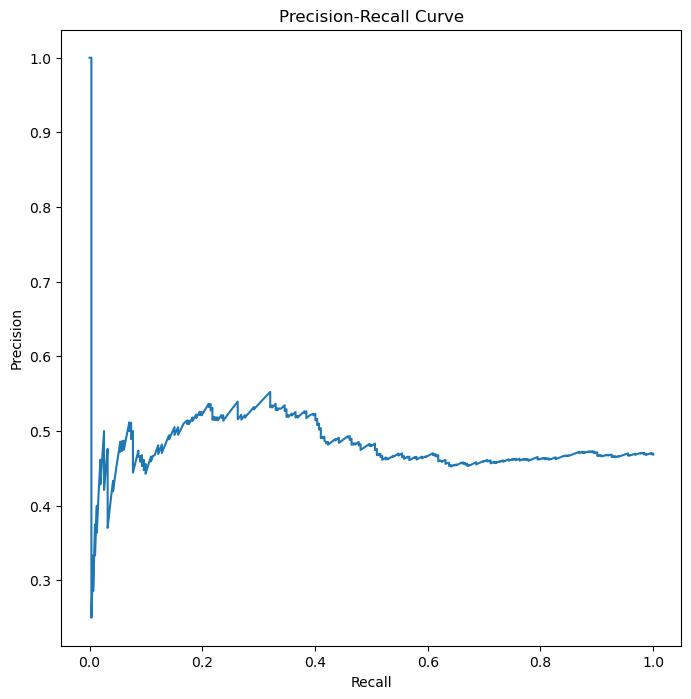

In [22]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

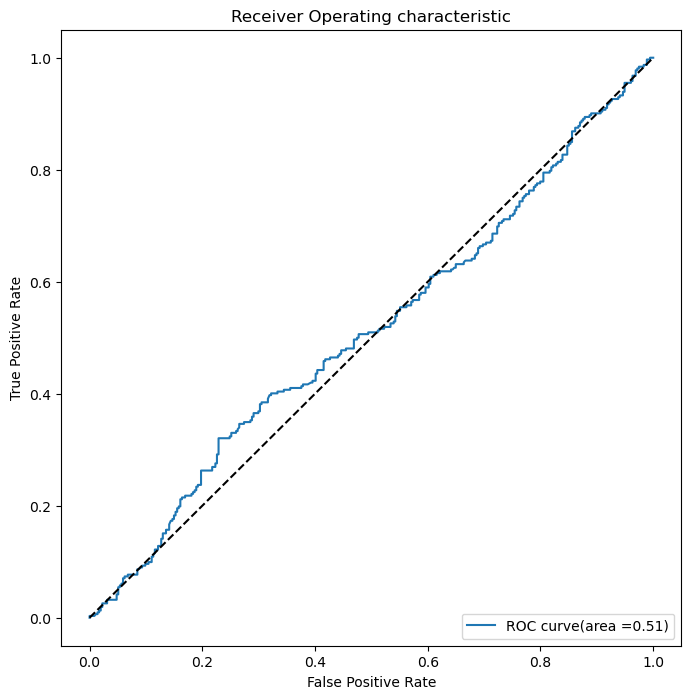

In [23]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [24]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.003205128205128205
specificity: 1.0
